In [1]:
# fixing directory to root of project
import git
import os
import sys

repo = git.Repo(".", search_parent_directories=True)
os.chdir(repo.working_tree_dir)
sys.path.append(repo.working_tree_dir)

import pandas as pd
import numpy as np
from scipy.stats import uniform, loguniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

from src.utils.utils import int_loguniform
from src.modelling.pipeline.ml_pipeline import (
    preprocess_features,
    preprocess_target,
    FilterFeatures,
    model_pipeline,
    )


from sklearn.datasets import load_iris


d:\Users\sean.ogara\.conda\envs\auto-ml\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
d:\Users\sean.ogara\.conda\envs\auto-ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load datasets
def load_sipher_datasets():
    sipher = pd.read_csv("Q:/SDU/simulation-modelling/data/SIPHER/synth_pop_dataset/csv/sp_ind_wavek_census2011_est2020_8cons.csv")
    us_ind = pd.read_table("Q:/SDU/simulation-modelling/data/SIPHER/understanding_society/tab/ukhls/k_indresp.tab")
    return sipher, us_ind


def get_individuals(us_ind):
    ind_vars = ['pidp', 'k_dvage', 'k_health', 'k_vegeamt', 'k_fruitamt',
                'k_vwhrs', 'k_mwhrs', 'k_ethn_dv',
                'k_helphours1','k_helphoursb1',
                'k_anypaya', 'k_payamta', 'k_allcosta',
                'k_hospc1', 'k_hospdc1',
                'k_brainnervtypn1', 'k_brainnervtypn2', 'k_brainnervtypn3',
                'k_brainnervtypn4', 'k_brainnervtypn5', 'k_brainnervtypn6']
    sipher_individuals = us_ind[ind_vars]
    return sipher_individuals


sipher, us_ind = load_sipher_datasets()
sipher_data = get_individuals(us_ind)


In [3]:
sipher_data["has_social_care"] = 0
sipher_data.loc[sipher_data["k_helphours1"] > 0, ["has_social_care"]] = 1

sipher_data["has_disability"] = 0
sipher_data.loc[sipher_data["k_health"] == 1, ["has_disability"]] = 1


D:\Users\sean.ogara\AppData\Local\Temp\1\ipykernel_11544\3844998724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sipher_data["has_social_care"] = 0
D:\Users\sean.ogara\AppData\Local\Temp\1\ipykernel_11544\3844998724.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sipher_data["has_disability"] = 0


In [4]:
# has been to hospital due to condition
sipher_data["hospital_condition"] = 0
sipher_data.loc[sipher_data["k_hospc1"] == 1, ["hospital_condition"]] = 1
neurological_conditions = ['k_brainnervtypn1', 'k_brainnervtypn2', 'k_brainnervtypn3','k_brainnervtypn4', 'k_brainnervtypn5', 'k_brainnervtypn6']
sipher_data["neuro_condition"] = 0
sipher_data.loc[(sipher_data[neurological_conditions] == 1).any(axis="columns"), "neuro_condition"] = 1

D:\Users\sean.ogara\AppData\Local\Temp\1\ipykernel_11544\738985845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sipher_data["hospital_condition"] = 0
D:\Users\sean.ogara\AppData\Local\Temp\1\ipykernel_11544\738985845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sipher_data["neuro_condition"] = 0


In [5]:
sipher_data["healthy_eater"] = 0
sipher_data.loc[sipher_data["k_fruitamt"] + sipher_data["k_vegeamt"] > 5, ["healthy_eater"]] = 1

sipher_data["physically_active"] = 0
sipher_data.loc[sipher_data["k_vwhrs"] + sipher_data["k_mwhrs"] > 2.5, ["physically_active"]] = 1

D:\Users\sean.ogara\AppData\Local\Temp\1\ipykernel_11544\3841004204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sipher_data["healthy_eater"] = 0
D:\Users\sean.ogara\AppData\Local\Temp\1\ipykernel_11544\3841004204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sipher_data["physically_active"] = 0


In [6]:
sipher_data["white_british"] = 0
sipher_data.loc[sipher_data["k_ethn_dv"] == 1, ["white_british"]] = 1


D:\Users\sean.ogara\AppData\Local\Temp\1\ipykernel_11544\1805225033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sipher_data["white_british"] = 0


In [7]:
sipher_data = sipher_data[["pidp", "healthy_eater", "physically_active", "has_social_care", "white_british", "has_disability", "k_dvage", "hospital_condition", "neuro_condition"]]

In [8]:
sipher_data.isna().any() == True

pidp                  False
healthy_eater         False
physically_active     False
has_social_care       False
white_british         False
has_disability        False
k_dvage               False
hospital_condition    False
neuro_condition       False
dtype: bool

       healthy_eater  physically_active  white_british  has_disability  \
8262               0                  0              1               0   
8414               0                  0              1               0   
25394              0                  0              0               0   
29875              1                  0              1               0   
27317              1                  0              1               1   
...              ...                ...            ...             ...   
7329               1                  0              1               0   
19368              1                  0              1               0   
25502              1                  0              0               0   
610                0                  0              1               1   
29317              0                  0              1               1   

       k_dvage  hospital_condition  neuro_condition  
8262        63                   0                0  
841

2025/04/01 14:23:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Users\sean.ogara\.conda\envs\auto-ml\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
d:\Users\sean.ogara\.conda\envs\auto-ml\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 1 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2025/04/01 14:23:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Users\sean.ogara\.conda\envs\auto-ml\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/04/01 14:24:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Users\sean.ogara\.conda\envs\auto-ml\

Creating evaluation plots
       healthy_eater  physically_active  white_british  has_disability  \
15187              0                  0              1               1   
3276               1                  0              1               0   
29091              0                  0              1               0   
5775               0                  0              1               0   
5654               0                  0              1               0   
...              ...                ...            ...             ...   
13852              0                  0              1               0   
24047              0                  0              0               0   
31669              1                  0              1               0   
8656               0                  0              1               0   
23006              0                  0              1               1   

       k_dvage  hospital_condition  neuro_condition  
15187       54                 

2025/04/01 14:24:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Users\sean.ogara\.conda\envs\auto-ml\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
d:\Users\sean.ogara\.conda\envs\auto-ml\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning:

The total space of parameters 1

Fitting 5 folds for each of 1 candidates, totalling 5 fits


2025/04/01 14:24:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Users\sean.ogara\.conda\envs\auto-ml\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/04/01 14:24:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Users\sean.ogara\.conda\envs\auto-ml\

Creating evaluation plots
       healthy_eater  physically_active  white_british  has_disability  \
15187              0                  0              1               1   
3276               1                  0              1               0   
29091              0                  0              1               0   
5775               0                  0              1               0   
5654               0                  0              1               0   
...              ...                ...            ...             ...   
13852              0                  0              1               0   
24047              0                  0              0               0   
31669              1                  0              1               0   
8656               0                  0              1               0   
23006              0                  0              1               1   

       k_dvage  hospital_condition  neuro_condition  
15187       54                 

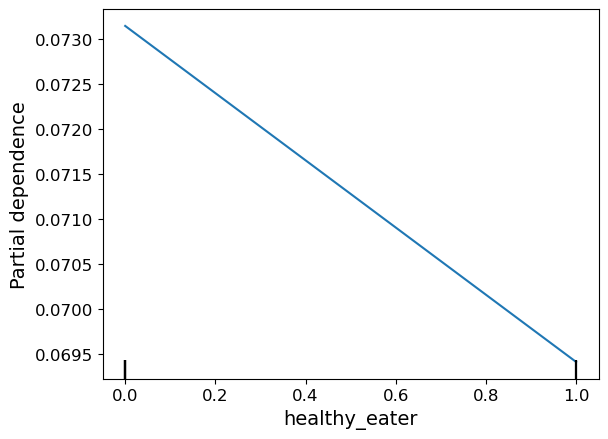

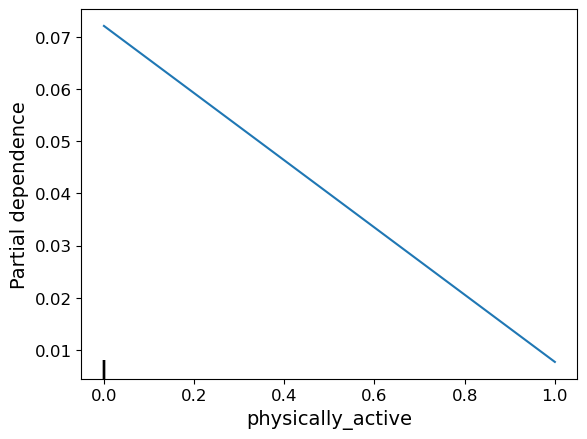

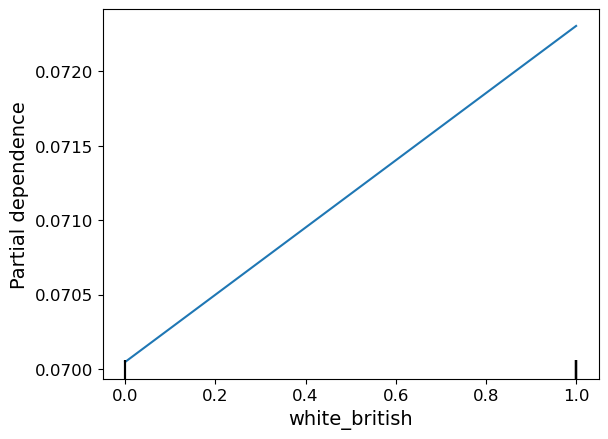

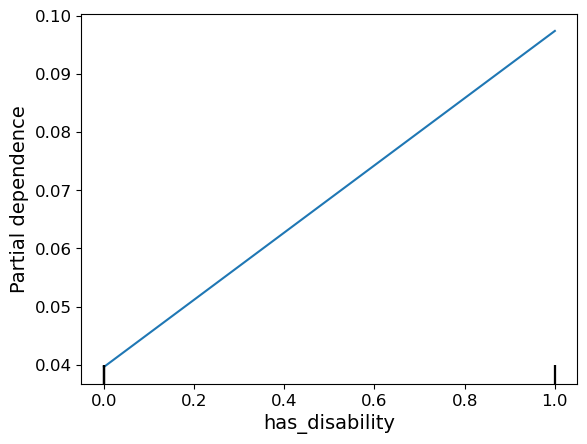

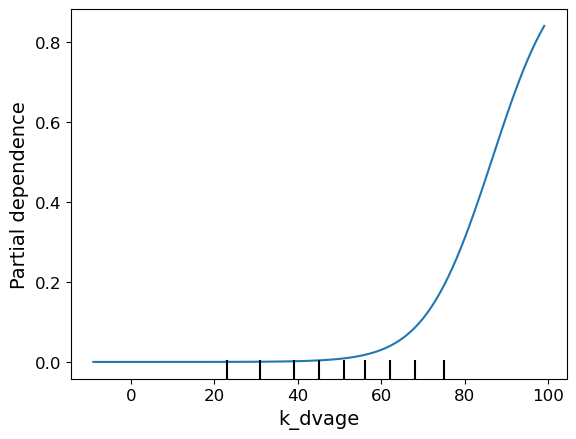

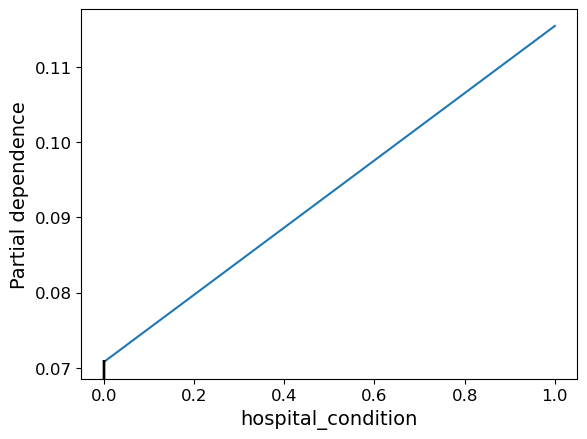

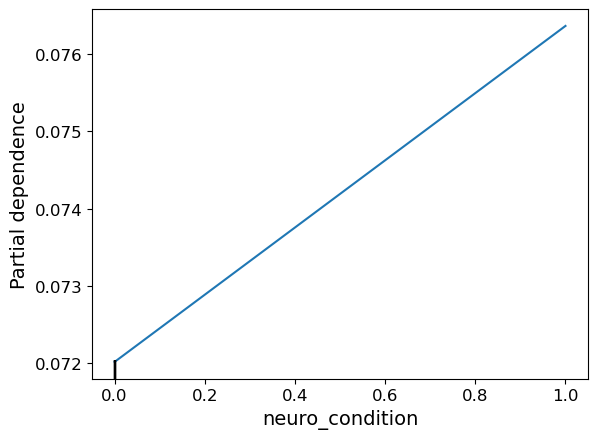

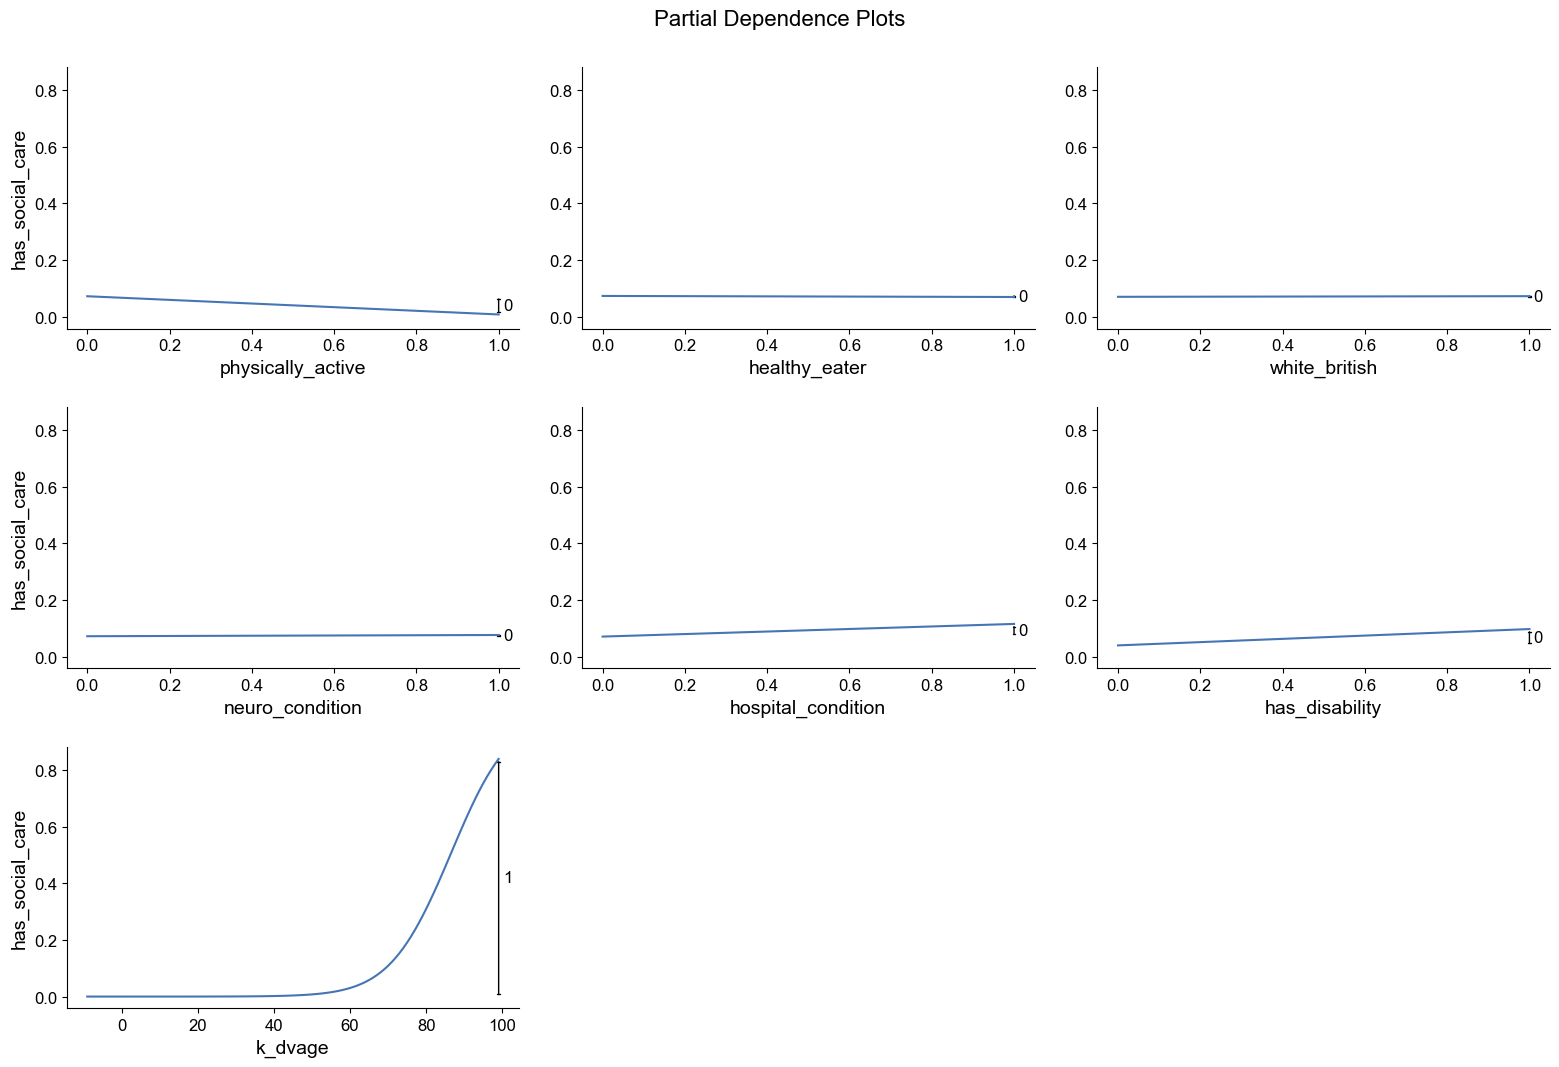

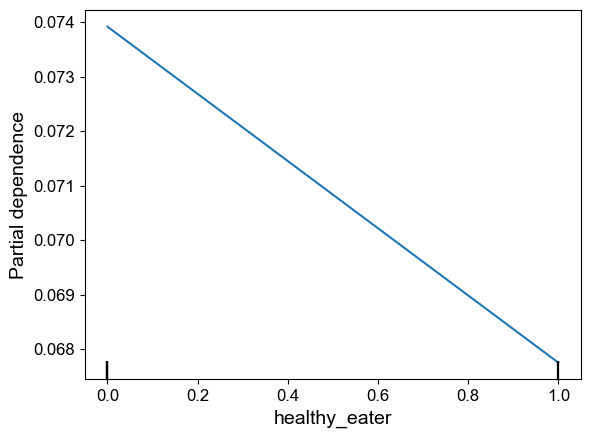

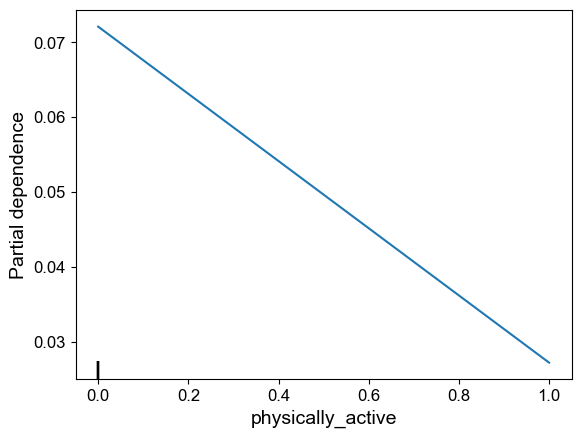

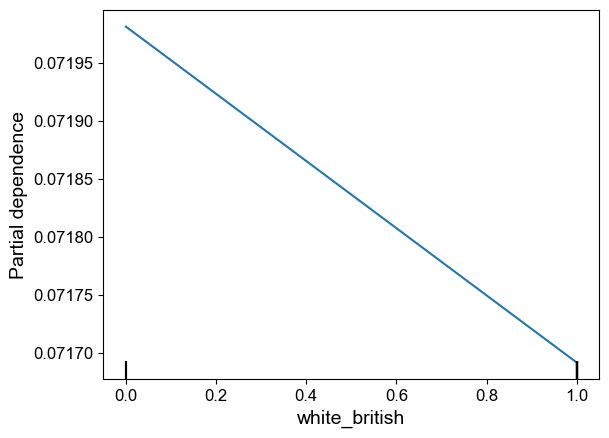

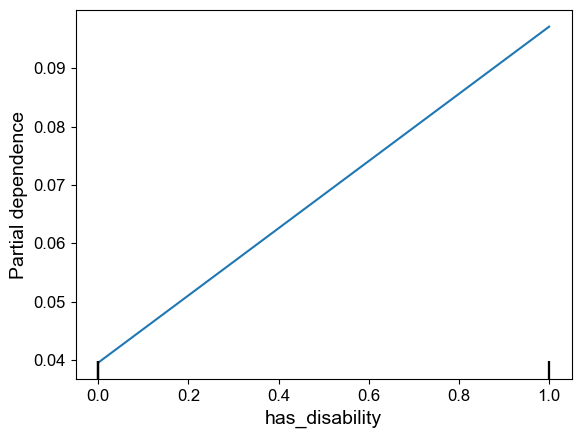

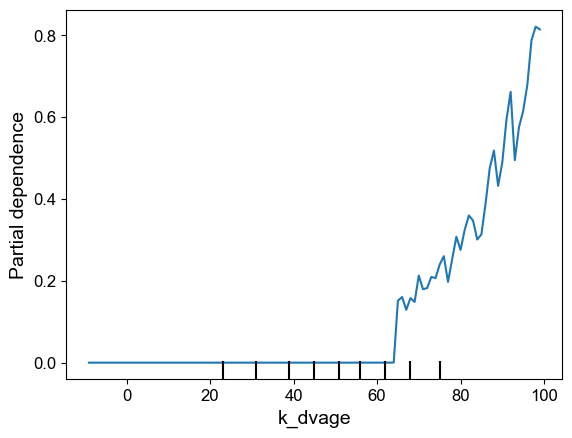

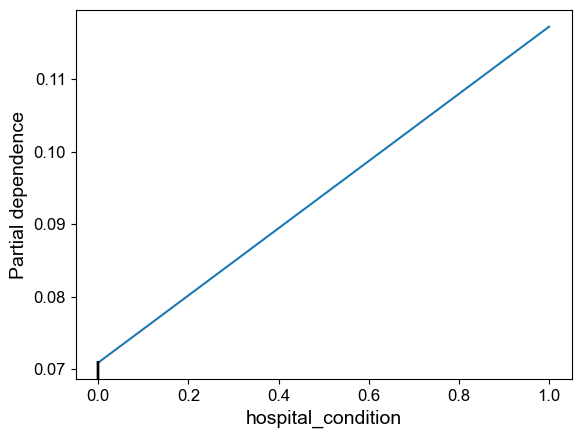

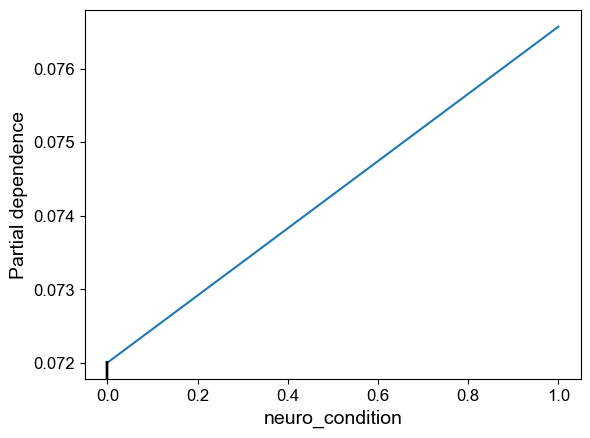

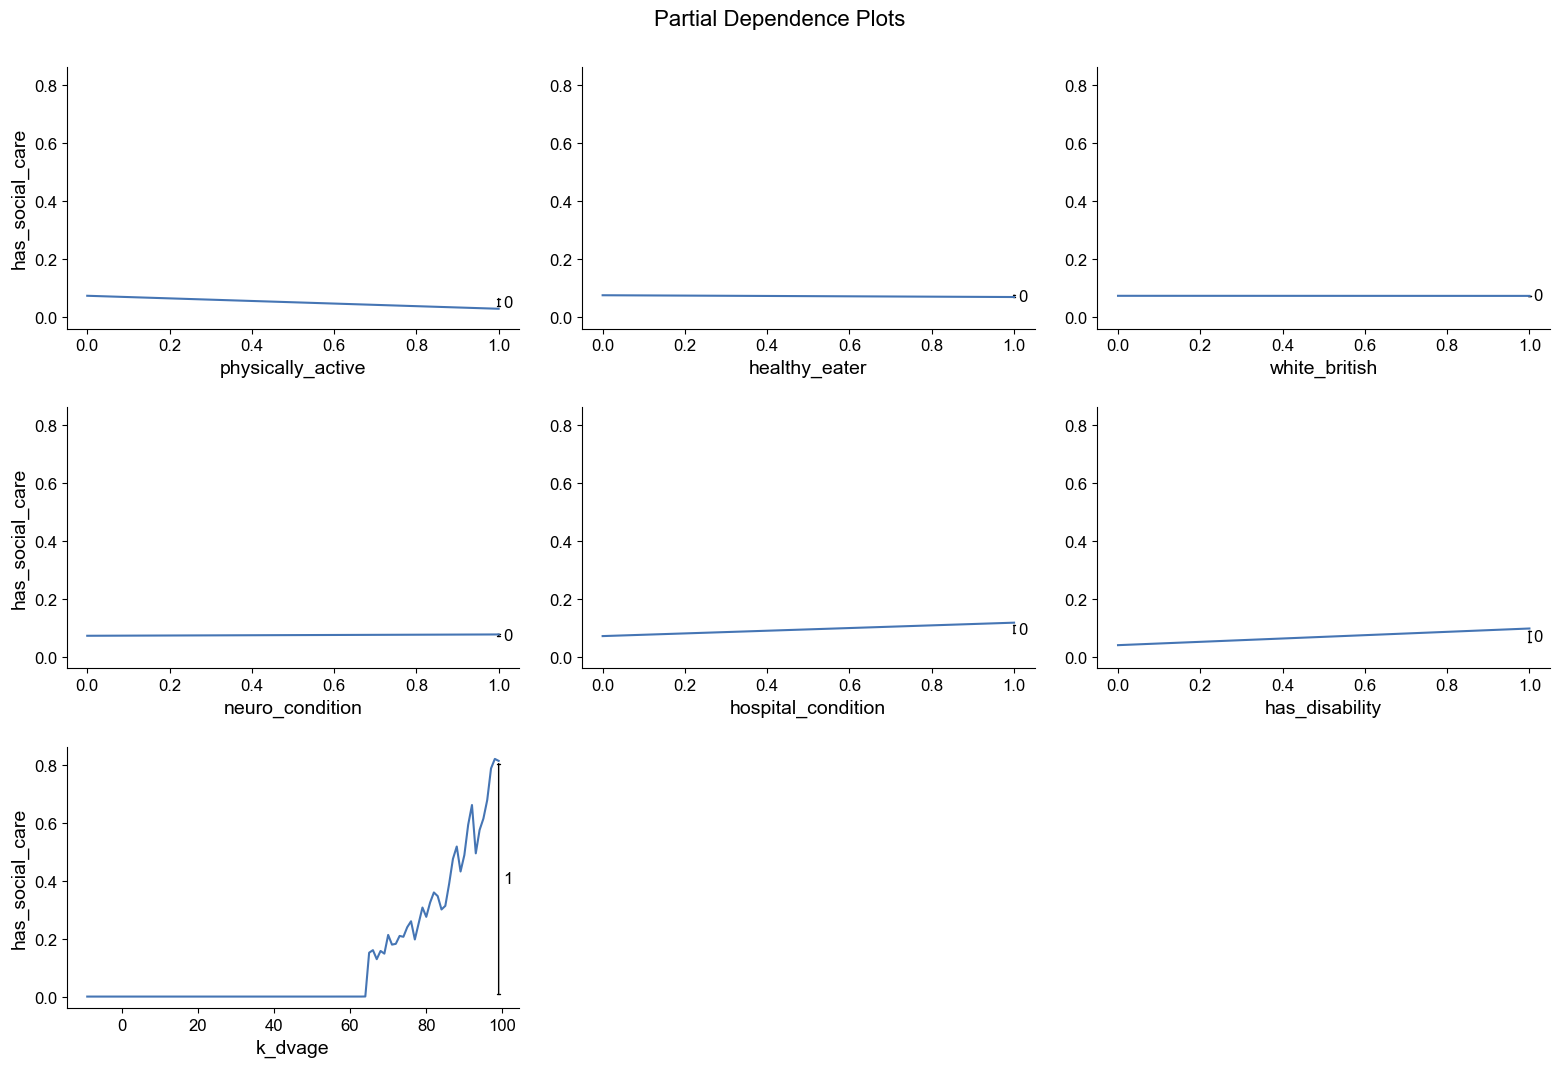

In [9]:
# target variables
target_var_list = ["has_social_care"]
# drop any unecessary variables from the model. In this case, we are dropping the geographical identifier.
drop_variables = ["pidp"]
# model dictionary and hyperparameter search space
model_param_dict = {
    LogisticRegression(): {},
    RandomForestClassifier(): {}
}
# optional controls:
# select features list - use to subset specific features of interest, if blank it will use all features.
# change feature_filter__filter_features hyperparam when using this
select_features_list = []
# optional - user specified model for evaluation plots. e.g. user_model = "Lasso"
# if left blank out the best performing model will be used for the evaluation plots
user_model = ""
# shortened feature name label for evaluation plots
col_labels = {}

# run pipeline for all models
for target_var in target_var_list:
    # pre-processing
    # drop cols, convert to set to drop unique cols only
    cols_to_drop = list(set([target_var] + drop_variables))
    features = preprocess_features(df=sipher_data, cols_to_drop=cols_to_drop)
    target_df = preprocess_target(df=sipher_data, target_col=target_var)

    # run model pipeline
    model_pipeline(
        model_param_dict=model_param_dict,
        target_var=target_var,
        target_df=target_df,
        feature_df=features,
        id_col="pidp",
        original_df=sipher_data,
        output_path="outputs",
        output_label="classification_sipher",
        col_label_map=col_labels,
        user_evaluation_model=user_model,
    )
